In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

# Summary

We will apply ensemble learning for face recognition models supported in [deepface for python](https://github.com/serengil/deepface).

Human beings have 97.53% score in face recognition task based on the [Facebook study](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/). 

So, can ensemble of the most popular face recognition models have a higher score than human beings?

# Data set

In [2]:
# Ref: https://github.com/serengil/deepface/tree/master/tests/dataset
idendities = {
    "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg", "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
    "Scarlett": ["img8.jpg", "img9.jpg", "img47.jpg", "img48.jpg", "img49.jpg", "img50.jpg", "img51.jpg"],
    "Jennifer": ["img3.jpg", "img12.jpg", "img53.jpg", "img54.jpg", "img55.jpg", "img56.jpg"],
    "Mark": ["img13.jpg", "img14.jpg", "img15.jpg", "img57.jpg", "img58.jpg"],
    "Jack": ["img16.jpg", "img17.jpg", "img59.jpg", "img61.jpg", "img62.jpg"],
    "Elon": ["img18.jpg", "img19.jpg", "img67.jpg"],
    "Jeff": ["img20.jpg", "img21.jpg"],
    "Marissa": ["img22.jpg", "img23.jpg"],
    "Sundar": ["img24.jpg", "img25.jpg"],
    "Katy": ["img26.jpg", "img27.jpg", "img28.jpg", "img42.jpg", "img43.jpg", "img44.jpg", "img45.jpg", "img46.jpg"],
    "Matt": ["img29.jpg", "img30.jpg", "img31.jpg", "img32.jpg", "img33.jpg"],
    "Leonardo": ["img34.jpg", "img35.jpg", "img36.jpg", "img37.jpg"],
    "George": ["img38.jpg", "img39.jpg", "img40.jpg", "img41.jpg"]
    
}

# Positive samples
Find different photos of same people

In [3]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [4]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [5]:
positives.shape

(140, 3)

# Negative samples
Compare photos of different people

In [6]:
samples_list = list(idendities.values())

In [7]:
negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)

In [8]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [9]:
negatives = negatives.sample(positives.shape[0])

In [10]:
negatives.shape

(140, 3)

# Merge Positives and Negative Samples

In [11]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [12]:
df.shape

(280, 3)

In [13]:
df.decision.value_counts()

No     140
Yes    140
Name: decision, dtype: int64

In [14]:
df.file_x = "deepface/tests/dataset/"+df.file_x
df.file_y = "deepface/tests/dataset/"+df.file_y

# DeepFace

In [15]:
#!pip install deepface
from deepface import DeepFace
from deepface.basemodels import VGGFace, OpenFace, Facenet, FbDeepFace

Using TensorFlow backend.


In [16]:
pretrained_models = {}

pretrained_models["VGG-Face"] = VGGFace.loadModel()
print("VGG-Face loaded")

pretrained_models["Facenet"] = Facenet.loadModel()
print("Facenet loaded")

pretrained_models["OpenFace"] = OpenFace.loadModel() 
print("OpenFace loaded")

pretrained_models["DeepFace"] = FbDeepFace.loadModel()
print("FbDeepFace loaded")

VGG-Face loaded
Facenet loaded
OpenFace loaded
FbDeepFace loaded


In [17]:
instances = df[["file_x", "file_y"]].values.tolist()

In [18]:
models = ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace']
metrics = ['cosine', 'euclidean', 'euclidean_l2']

In [19]:
if True:
    for model in models:
        for metric in metrics:
            
            print("Processing ",model," ",metric)
            
            if model == 'OpenFace' and metric == 'euclidean': #this returns same with openface euclidean l2
                continue
            else:
                resp_obj = DeepFace.verify(instances
                                           , model_name = model
                                           , model = pretrained_models[model]
                                           , distance_metric = metric)

                distances = []

                for i in range(0, len(instances)):
                    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
                    distances.append(distance)

                df['%s_%s' % (model, metric)] = distances
    
    df.to_csv("face-recognition-pivot.csv", index = False)
else:
    #Ref: https://github.com/serengil/deepface/blob/master/tests/dataset/face-recognition-pivot.csv
    df = pd.read_csv("face-recognition-pivot.csv")

Processing  VGG-Face   cosine
Already built model is passed


Verification: 100%|██████████| 280/280 [11:31<00:00,  2.47s/it]


Processing  VGG-Face   euclidean
Already built model is passed


Verification: 100%|██████████| 280/280 [11:47<00:00,  2.53s/it]


Processing  VGG-Face   euclidean_l2
Already built model is passed


Verification: 100%|██████████| 280/280 [11:31<00:00,  2.47s/it]


Processing  Facenet   cosine
Already built model is passed


Verification: 100%|██████████| 280/280 [07:51<00:00,  1.69s/it]


Processing  Facenet   euclidean
Already built model is passed


Verification: 100%|██████████| 280/280 [07:46<00:00,  1.67s/it]


Processing  Facenet   euclidean_l2
Already built model is passed


Verification: 100%|██████████| 280/280 [07:51<00:00,  1.68s/it]


Processing  OpenFace   cosine
Already built model is passed


Verification: 100%|██████████| 280/280 [05:51<00:00,  1.25s/it]


Processing  OpenFace   euclidean
Processing  OpenFace   euclidean_l2
Already built model is passed


Verification: 100%|██████████| 280/280 [05:58<00:00,  1.28s/it]


Processing  DeepFace   cosine
Already built model is passed


Verification: 100%|██████████| 280/280 [06:12<00:00,  1.33s/it]


Processing  DeepFace   euclidean
Already built model is passed


Verification: 100%|██████████| 280/280 [05:55<00:00,  1.27s/it]


Processing  DeepFace   euclidean_l2
Already built model is passed


Verification: 100%|██████████| 280/280 [05:56<00:00,  1.27s/it]


In [20]:
df_raw = df.copy()

In [21]:
df.head()

,file_x,file_y,decision,VGG-Face_cosine,VGG-Face_euclidean,VGG-Face_euclidean_l2,Facenet_cosine,Facenet_euclidean,Facenet_euclidean_l2,OpenFace_cosine,OpenFace_euclidean_l2,DeepFace_cosine,DeepFace_euclidean,DeepFace_euclidean_l2
0,deepface/tests/dataset/img38.jpg,deepface/tests/dataset/img39.jpg,Yes,0.2057,0.3890,0.6414,0.1601,6.8679,0.5658,0.5925,1.0886,0.2554,61.3336,0.7147
1,deepface/tests/dataset/img38.jpg,deepface/tests/dataset/img40.jpg,Yes,0.2117,0.3179,0.6508,0.2739,8.9049,0.7402,0.3960,0.8899,0.2685,63.3747,0.7328
2,deepface/tests/dataset/img38.jpg,deepface/tests/dataset/img41.jpg,Yes,0.1073,0.2482,0.4632,0.1257,6.1593,0.5014,0.7157,1.1964,0.2452,60.3454,0.7002
3,deepface/tests/dataset/img39.jpg,deepface/tests/dataset/img40.jpg,Yes,0.2991,0.4567,0.7734,0.3134,9.3798,0.7917,0.4941,0.9941,0.1703,45.1688,0.5836
4,deepface/tests/dataset/img39.jpg,deepface/tests/dataset/img41.jpg,Yes,0.1666,0.3542,0.5772,0.1502,6.6491,0.5481,0.2381,0.6901,0.2194,50.4356,0.6624


# Distribution

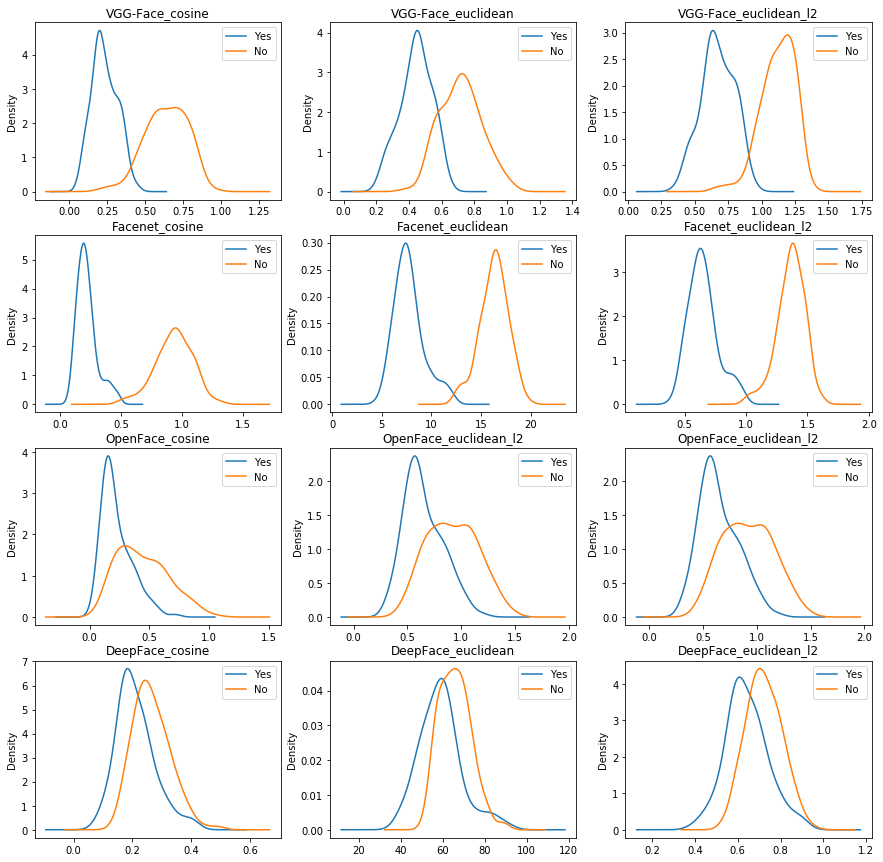

In [24]:
fig = plt.figure(figsize=(15, 15))

figure_idx = 1
for model in models:
    for metric in metrics:
        
        if model == 'OpenFace' and metric == 'euclidean': #this returns same with openface euclidean l2
            metric = 'euclidean_l2'
        
        feature = '%s_%s' % (model, metric)

        ax1 = fig.add_subplot(4, 3, figure_idx)
        
        df[df.decision == "Yes"][feature].plot(kind='kde', title = feature, label = 'Yes', legend = True)
        df[df.decision == "No"][feature].plot(kind='kde', title = feature, label = 'No', legend = True)
        
        figure_idx = figure_idx + 1

plt.show()

# Pre-processing for model

In [25]:
columns = []
for model in models:
    for metric in metrics:
        if model == 'OpenFace' and metric == 'euclidean':
            continue
        else:
            feature = '%s_%s' % (model, metric)
            columns.append(feature)

columns.append("decision")

In [26]:
df = df[columns]

In [27]:
df.loc[df[df.decision == 'Yes'].index, 'decision'] = 1
df.loc[df[df.decision == 'No'].index, 'decision'] = 0

In [28]:
df.head()

,VGG-Face_cosine,VGG-Face_euclidean,VGG-Face_euclidean_l2,Facenet_cosine,Facenet_euclidean,Facenet_euclidean_l2,OpenFace_cosine,OpenFace_euclidean_l2,DeepFace_cosine,DeepFace_euclidean,DeepFace_euclidean_l2,decision
0,0.2057,0.3890,0.6414,0.1601,6.8679,0.5658,0.5925,1.0886,0.2554,61.3336,0.7147,1
1,0.2117,0.3179,0.6508,0.2739,8.9049,0.7402,0.3960,0.8899,0.2685,63.3747,0.7328,1
2,0.1073,0.2482,0.4632,0.1257,6.1593,0.5014,0.7157,1.1964,0.2452,60.3454,0.7002,1
3,0.2991,0.4567,0.7734,0.3134,9.3798,0.7917,0.4941,0.9941,0.1703,45.1688,0.5836,1
4,0.1666,0.3542,0.5772,0.1502,6.6491,0.5481,0.2381,0.6901,0.2194,50.4356,0.6624,1


# Train test split

In [163]:
from sklearn.model_selection import train_test_split

In [220]:
df_train, df_test = train_test_split(df, test_size=0.50, random_state=34)
#df_test, df_val = train_test_split(df_test, test_size=0.50, random_state=17)

In [221]:
target_name = "decision"

y_train = df_train[target_name].values
x_train = df_train.drop(columns=[target_name]).values

y_test = df_test[target_name].values
x_test = df_test.drop(columns=[target_name]).values

# LightGBM

In [222]:
import lightgbm as lgb

In [223]:
features = df.drop(columns=[target_name]).columns.tolist()

lgb_train = lgb.Dataset(x_train, y_train, feature_name = features)
lgb_test = lgb.Dataset(x_test, y_test, feature_name = features)
#lgb_val = lgb.Dataset(x_val, y_val, feature_name = features)

In [224]:
params = {
    'task': 'train'
    , 'boosting_type': 'gbdt'
    , 'objective': 'multiclass'
    , 'num_class': 2
    , 'metric': 'multi_logloss'
}

In [225]:
gbm = lgb.train(params, lgb_train, num_boost_round=250, early_stopping_rounds = 15 , valid_sets=[lgb_test])

[1]	valid_0's multi_logloss: 0.608604
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 0.531756
[3]	valid_0's multi_logloss: 0.467911
[4]	valid_0's multi_logloss: 0.419189
[5]	valid_0's multi_logloss: 0.372591
[6]	valid_0's multi_logloss: 0.337312
[7]	valid_0's multi_logloss: 0.30683
[8]	valid_0's multi_logloss: 0.275802
[9]	valid_0's multi_logloss: 0.249638
[10]	valid_0's multi_logloss: 0.225466
[11]	valid_0's multi_logloss: 0.208234
[12]	valid_0's multi_logloss: 0.189504
[13]	valid_0's multi_logloss: 0.172336
[14]	valid_0's multi_logloss: 0.16081
[15]	valid_0's multi_logloss: 0.147741
[16]	valid_0's multi_logloss: 0.135219
[17]	valid_0's multi_logloss: 0.127531
[18]	valid_0's multi_logloss: 0.117658
[19]	valid_0's multi_logloss: 0.111598
[20]	valid_0's multi_logloss: 0.103025
[21]	valid_0's multi_logloss: 0.0959946
[22]	valid_0's multi_logloss: 0.0923286
[23]	valid_0's multi_logloss: 0.0857837
[24]	valid_0's multi_logloss: 0.0801744
[25]	valid

In [226]:
#Ref: https://github.com/serengil/deepface/blob/master/models/face-recognition-ensemble-model.txt
gbm.save_model("face-recognition-ensemble-model.txt")

# Evaluation

In [227]:
predictions = gbm.predict(x_test)

In [228]:
prediction_classes = []
classified = 0

index = 0
for prediction in predictions:
    prediction_class = np.argmax(prediction)
    prediction_classes.append(prediction_class)
    
    actual = y_test[index]
    
    #print("prediction is ",prediction_class," whereas actual is ",actual)
    if actual == prediction_class:
        classified = classified + 1
    
    index = index + 1

#print(classified," instances are classified in ",len(predictions)," instances") 
print("accuracy: ",round(100*classified/len(predictions),2),"%")

accuracy:  98.57 %


In [229]:
cm = confusion_matrix(y_test, prediction_classes)

In [230]:
cm

array([[67,  1],
       [ 1, 71]], dtype=int64)

In [231]:
tn, fp, fn, tp = cm.ravel()

In [232]:
tn, fp, fn, tp

(67, 1, 1, 71)

In [233]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [234]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  98.61111111111111 %
Recall:  98.61111111111111 %
F1 score  98.61111111111111 %
Accuracy:  98.57142857142858 %


In [277]:
human_limit = 97.53

if 100*accuracy > human_limit:
    print("ensemble method is more successful than human beings!")
else:
    print("human beings are still more successful than the ensemble of face recognition models")

ensemble method is more successful than human beings!


# Interpretability

<Figure size 504x504 with 0 Axes>

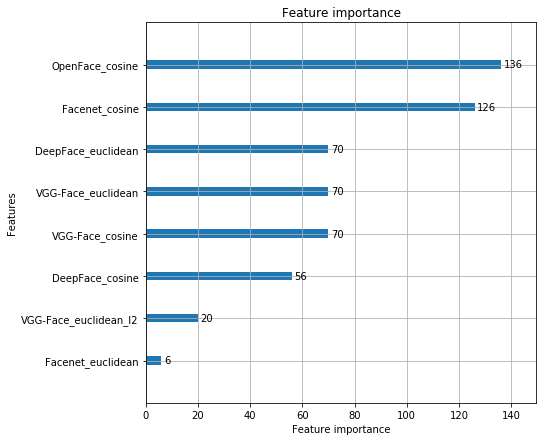

In [235]:
plt.figure(figsize=(7,7))
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

In [236]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

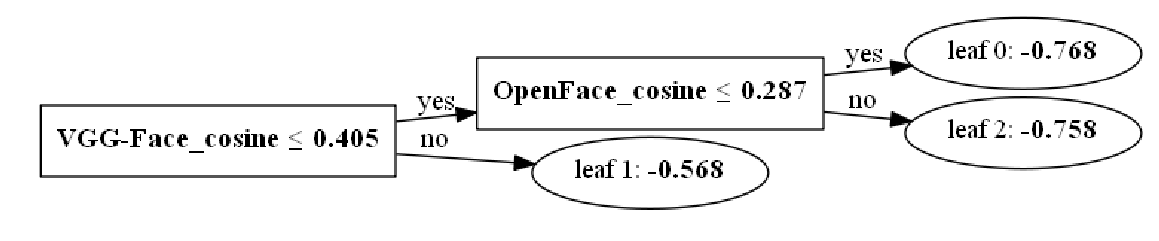

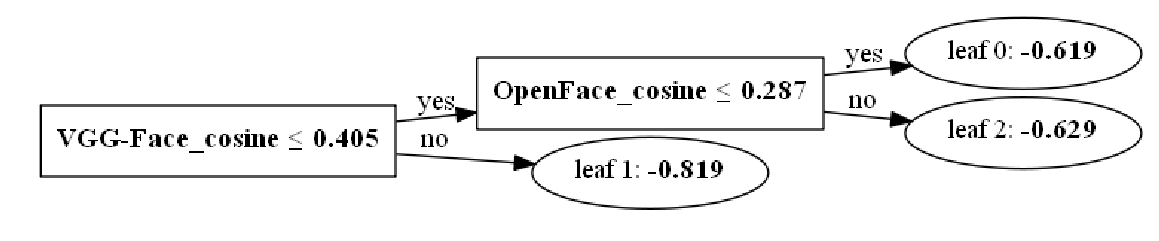

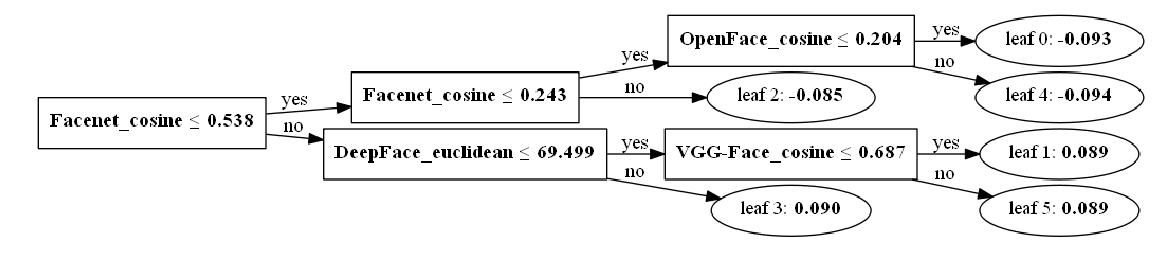

In [237]:
plt.rcParams["figure.figsize"] = [20, 20]

for i in range(0, gbm.num_trees()):
    ax = lgb.plot_tree(gbm, tree_index = i)
    plt.show()
    
    if i == 2:
        break

# ROC Curve

In [238]:
y_pred_proba = predictions[::,1]

In [239]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

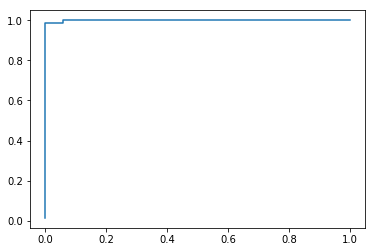

In [240]:
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

# Running ensemble model directly

In [243]:
#Ref: https://github.com/serengil/deepface/blob/master/models/face-recognition-ensemble-model.txt
deepface_ensemble = lgb.Booster(model_file= 'face-recognition-ensemble-model.txt')

In [276]:
#bulk predictions
#bulk_predictions = deepface_ensemble.predict(x_test)

In [273]:
#single prediction
idx = 0
verified = np.argmax(deepface_ensemble.predict(np.expand_dims(df.iloc[idx].values[0:-1], axis=0).shape)[0]) == 1
print("verified: ", verified)

verified:  True
